# Model 4: causal inference analysis to estimate the effect of adjuvant hormonal therapy on outcomes.

In [25]:
%pip install tableone

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from tqdm.notebook import tqdm
from tableone import TableOne
# %pip install tableone
df4 = pd.read_csv('../rotterdam.csv')

**Research Question**

Among patients who received hormonal therapy, what is the causal effect of the treatment on recurrence and mortality compared with similar untreated patients?

In [27]:
cutoff = 10
df4['er_cat'] = (df4['er'] >= cutoff).astype(int)
df4['pgr_cat'] = (df4['pgr'] >= cutoff).astype(int)

# log(nodes + 1)
df4['log_nodes'] = np.log1p(df4['nodes'])

In [28]:
num_vars = ['age', 'log_nodes']
cat_vars = ['grade', 'pgr_cat', 'er_cat', 'size']

<Axes: xlabel='hormon'>

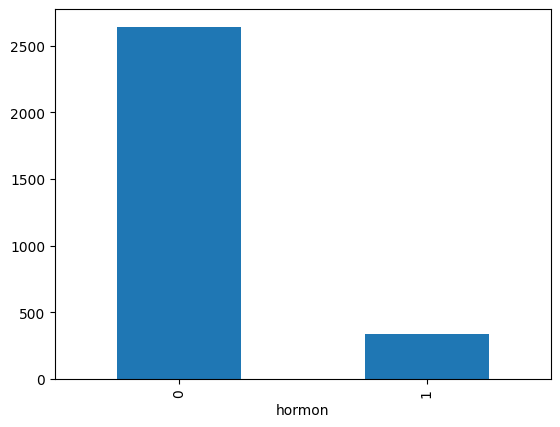

In [29]:
df4["hormon"].value_counts().plot(kind="bar")

The cohort is highly unbalanced with respect to hormonal therapy, with the vast majority of patients not receiving hormon treatment. This imbalance justifies its cautious use in modeling and supports sensitivity analyses excluding treated patients

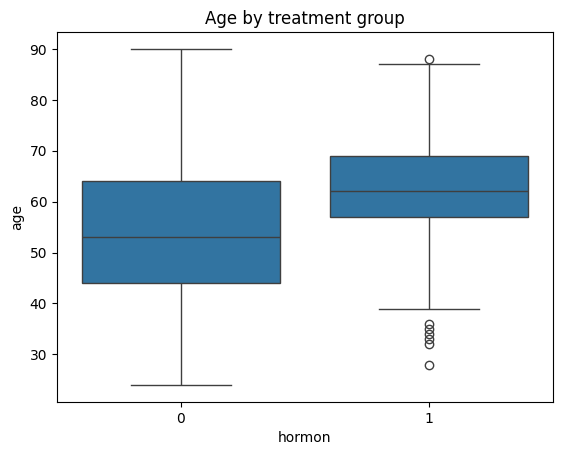

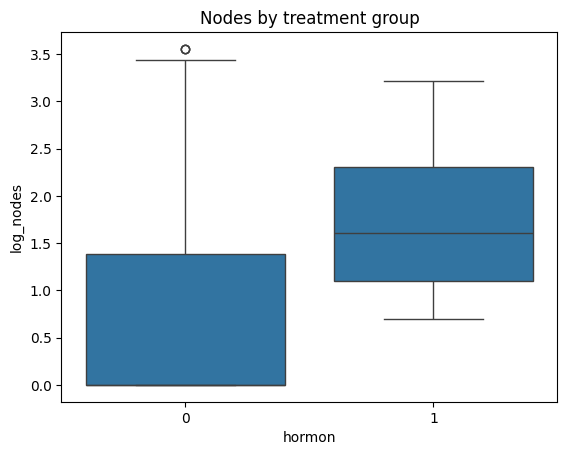

In [30]:
sns.boxplot(x="hormon", y="age", data=df4)
plt.title("Age by treatment group")
plt.show()

sns.boxplot(x="hormon", y="log_nodes", data=df4)
plt.title("Nodes by treatment group")
plt.show()

Patients receiving hormonal therapy tend to be older and present with higher nodal burden than untreated patients, indicating non-random treatment assignment. These patterns are consistent with clinical practice and point to confounding by indication in treatment–outcome analyses.

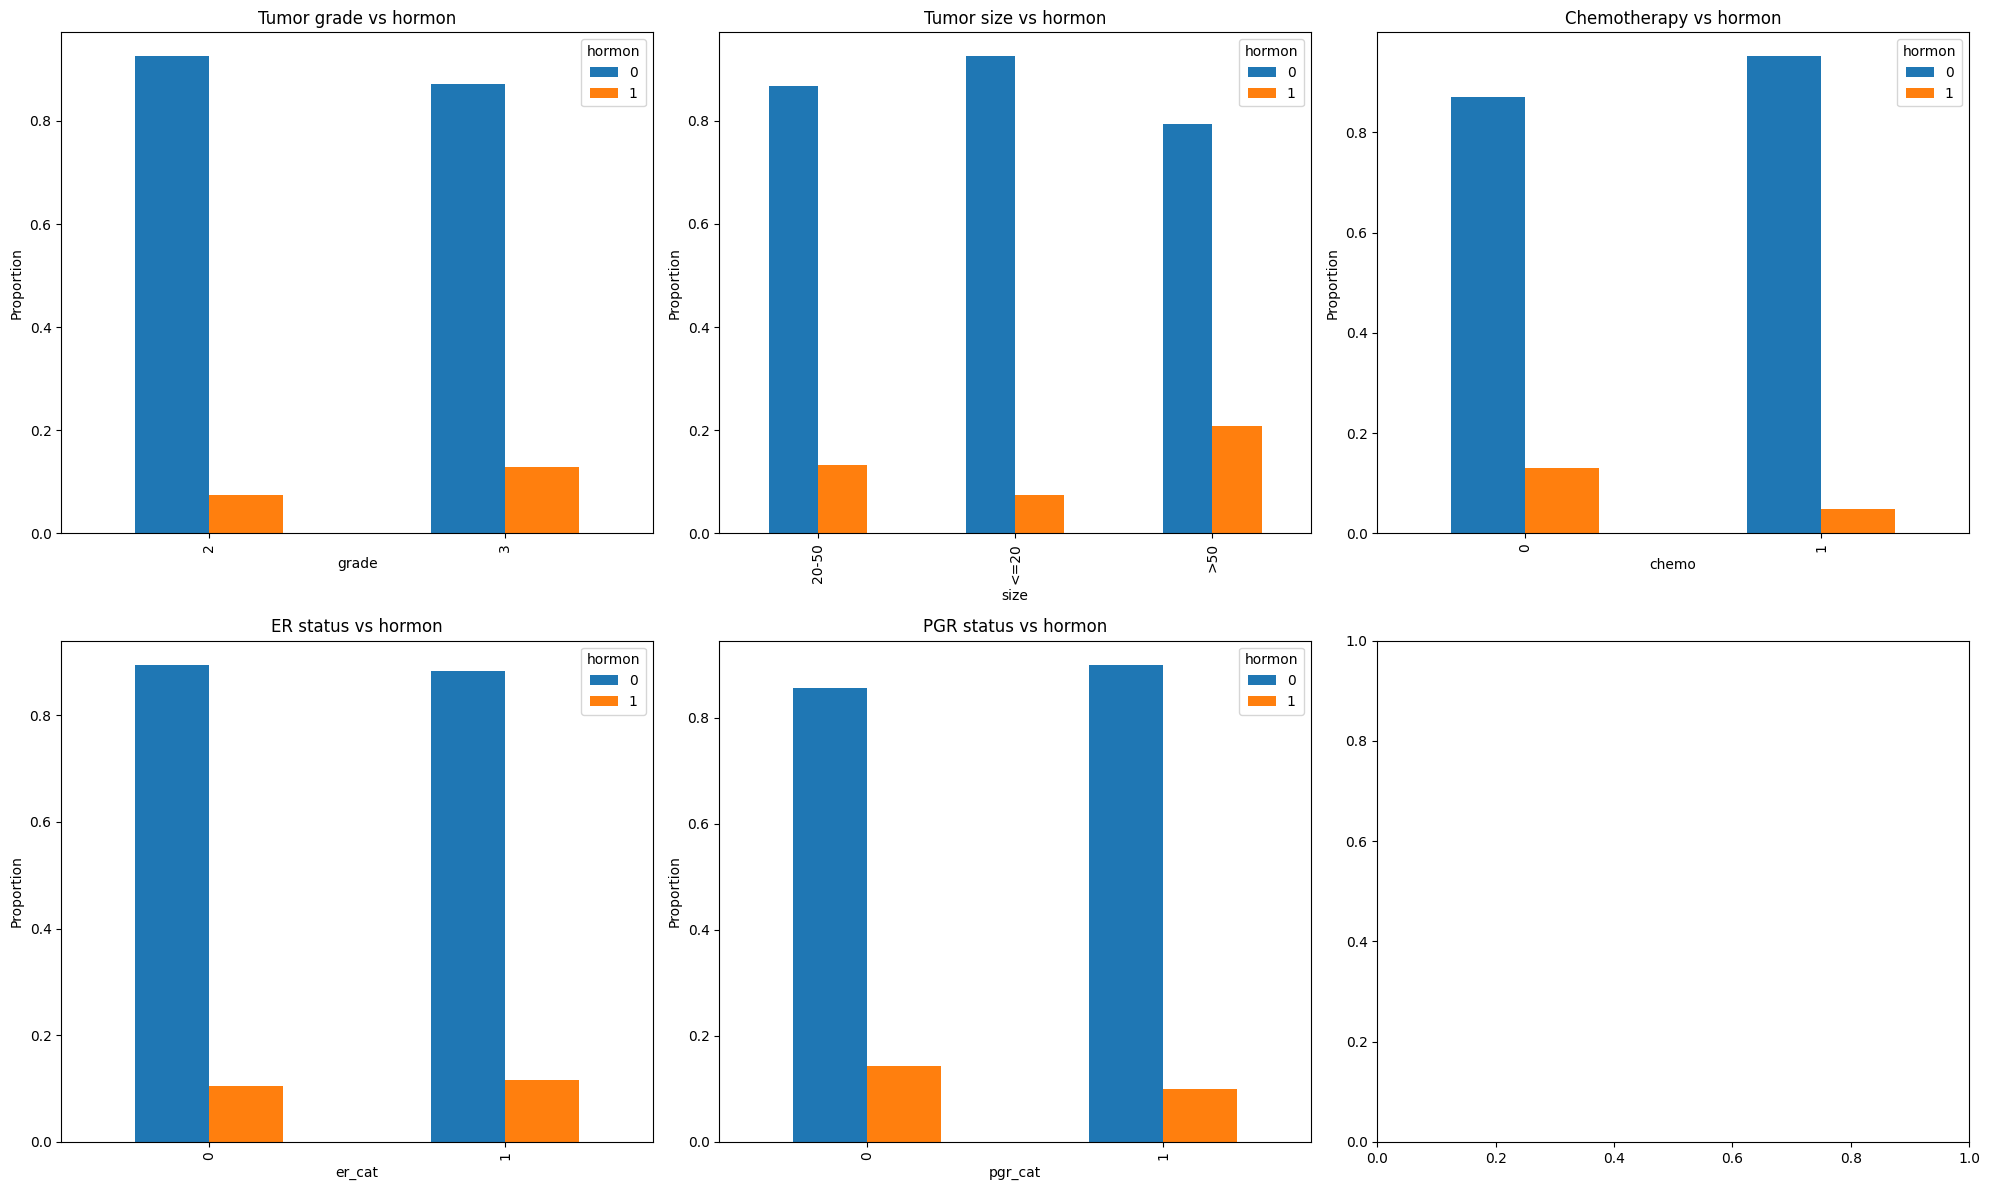

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))


axes = axes.flatten()


pd.crosstab(df4["grade"], df4["hormon"], normalize="index").plot(kind="bar", stacked=False, ax=axes[0])
axes[0].set_title("Tumor grade vs hormon")
axes[0].set_ylabel("Proportion")


pd.crosstab(df4["size"], df4["hormon"], normalize="index").plot(kind="bar", stacked=False, ax=axes[1])
axes[1].set_title("Tumor size vs hormon")
axes[1].set_ylabel("Proportion")


pd.crosstab(df4["chemo"], df4["hormon"], normalize="index").plot(kind="bar", stacked=False, ax=axes[2])
axes[2].set_title("Chemotherapy vs hormon")
axes[2].set_ylabel("Proportion")


pd.crosstab(df4["er_cat"], df4["hormon"], normalize="index").plot(kind="bar", stacked=False, ax=axes[3])
axes[3].set_title("ER status vs hormon")
axes[3].set_ylabel("Proportion")


pd.crosstab(df4["pgr_cat"], df4["hormon"], normalize="index").plot(kind="bar", stacked=False, ax=axes[4])
axes[4].set_title("PGR status vs hormon")
axes[4].set_ylabel("Proportion")

plt.tight_layout()
plt.show()

Hormonal therapy is more frequently administered to patients with higher tumor grade, larger tumor size, greater nodal involvement, and hormone receptor positivity, and is less common among those receiving chemotherapy. Overall, these patterns confirm substantial baseline differences between treatment groups, consistent with confounding by indication.

A Welch’s t-test is used to compare variables between patients treated and not treated with hormonal therapy, allowing for unequal variances. The resulting p-value assesses whether the age difference between groups is statistically significant.

In [32]:
from scipy.stats import ttest_ind, chi2_contingency

# age
t_stat, p_val = ttest_ind(
    df4.loc[df4["hormon"]==1, "age"],
    df4.loc[df4["hormon"]==0, "age"],
    equal_var=False
)
p_val

np.float64(1.071765881859008e-38)

In [34]:
# pgr
t_stat, p_val = ttest_ind(
    df4.loc[df4["hormon"]==1, "pgr_cat"],
    df4.loc[df4["hormon"]==0, "pgr_cat"],
    equal_var=False
)
p_val

np.float64(0.0007026572669357329)

In [36]:
# er
t_stat, p_val = ttest_ind(
    df4.loc[df4["hormon"]==1, "er_cat"],
    df4.loc[df4["hormon"]==0, "er_cat"],
    equal_var=False
)
p_val

np.float64(0.40232748411371755)

Estrogen Receptor (ER) status could acts as a critical confounder for the administration of hormonal therapy

In [37]:
# size
size_mapping = {'<=20': 0, '20-50': 1, '>50': 2}

df_temp_size = df4.copy() # Changed from df.copy() to df4.copy()
df_temp_size['size_numeric'] = df_temp_size['size'].map(size_mapping)

t_stat, p_val = ttest_ind(
    df_temp_size.loc[df_temp_size["hormon"]==1, "size_numeric"],
    df_temp_size.loc[df_temp_size["hormon"]==0, "size_numeric"],
    equal_var=False
)
p_val

np.float64(2.0670293663419588e-11)

In [40]:
# age
t_stat, p_val = ttest_ind(
    df4.loc[df4["hormon"]==1, "age"],
    df4.loc[df4["hormon"]==0, "age"],
    equal_var=False
)
p_val

np.float64(1.071765881859008e-38)

In [42]:
# log_nodes
t_stat, p_val = ttest_ind(
    df4.loc[df4["hormon"]==1, "log_nodes"],
    df4.loc[df4["hormon"]==0, "log_nodes"],
    equal_var=False
)
p_val

np.float64(1.0164706702233858e-81)

In [65]:
# chemo
t_stat, p_val = ttest_ind(
    df4.loc[df4["hormon"]==1, "chemo"],
    df4.loc[df4["hormon"]==0, "chemo"],
    equal_var=False
)
p_val

np.float64(3.503247910521749e-13)

In [66]:
df4_enc= df4.drop(columns=['er', 'pgr', 'nodes', 'year','hospital_id','pid'])

Patients receiving both chemotherapy and hormonal therapy were excluded to avoid treatment contamination. In the presence of combined therapies, the observed outcome reflects the joint effect of multiple interventions, making it impossible to disentangle the specific causal contribution of hormonal therapy alone. Restricting the analysis to patients not exposed to concurrent chemotherapy improves identifiability of the hormonal therapy effect under the causal inference framework.

In [67]:
n_both = df4_enc[(df4_enc['chemo'] == 1) & (df4_enc['hormon'] == 1)].shape[0]
print("Patients receiving both chemotherapy and hormonal therapy:", n_both)
print(f"Percentage: {n_both / df4_enc.shape[0] * 100:.2f}%")

Patients receiving both chemotherapy and hormonal therapy: 28
Percentage: 0.94%


In [68]:
df4_enc = df4_enc[~((df4_enc['chemo'] == 1) & (df4_enc['hormon'] == 1))].copy()

In [69]:
df4_enc["hormon"].value_counts(normalize=True)

hormon
0    0.894719
1    0.105281
Name: proportion, dtype: float64

**Propensity Score estimation**

Propensity score matching was chosen because the primary estimand of interest is the Average Treatment Effect on the Treated (ATT). Matching naturally targets the ATT by constructing a credible counterfactual for treated patients within the region of common support. In this observational setting, treatment assignment is highly non-random and not all patients are eligible for hormonal therapy, leading to confounding by indication and limited overlap. Compared to IPTW, which is more suitable for estimating the ATE and relies on stronger modeling assumptions, matching provides a more robust and clinically interpretable estimate of the treatment effect in the treated population.

In [70]:
confounders = ['age', 'log_nodes', 'grade', 'size', 'er_cat', 'pgr_cat']

# Ensure df_match contains all necessary columns and is a DataFrame
df_match = df4_enc[confounders + ['hormon']].copy()
# It's good practice to drop rows with NaN values in confounders before matching
df_match = df_match.dropna(subset=confounders + ['hormon'])

 A set of clinically relevant confounders is selected to model treatment assignment, and a clean matching dataset is created by retaining only these variables and the treatment indicator

In [ ]:
num_vars = ['age', 'log_nodes']
cat_vars = ['grade', 'pgr_cat', 'er_cat', 'size']

# one-hot encoding of categorical features
df_match_enc = pd.concat([
    df_match.drop(columns=cat_vars),
    pd.get_dummies(df_match[cat_vars], columns=cat_vars, drop_first=True).astype(int)
], axis=1)

print(df_match_enc)

      age  log_nodes  hormon  grade_3  pgr_cat_1  er_cat_1  size_<=20  \
0      74   0.000000       0        1          1         1          1   
1      79   0.000000       0        1          1         1          0   
2      44   0.000000       0        0          1         0          1   
3      70   0.000000       0        1          0         1          0   
4      75   0.000000       0        1          1         1          1   
...   ...        ...     ...      ...        ...       ...        ...   
2977   73   0.693147       0        1          1         1          0   
2978   75   2.484907       1        1          0         1          0   
2979   79   1.945910       0        1          1         1          0   
2980   71   0.000000       0        1          0         1          1   
2981   68   2.564949       1        1          0         0          1   

      size_>50  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
2977

In [72]:
from sklearn.preprocessing import StandardScaler

T = 'hormon'
X = df_match_enc.columns.drop([T])

# Standardize numerical variables
scaler = StandardScaler()
df_match_enc[num_vars] = scaler.fit_transform(df_match_enc[num_vars])

# Fit the logistic regression model
ps_model = LogisticRegression(C=1e6).fit(df_match_enc[X], df_match_enc[T])

# Add propensity scores to the dataset
data_ps = df4_enc.assign(propensity_score=ps_model.predict_proba(df_match_enc[X])[:, 1])

Covariates are standardized and used in a logistic regression model to estimate each patient’s probability of receiving hormonal therapy. The resulting propensity scores are then added to the dataset to support subsequent marching.

In [73]:
data_ps

,age,meno,size,grade,hormon,chemo,rtime,recur,dtime,death,er_cat,pgr_cat,log_nodes,propensity_score
0,74,1,<=20,3,0,0,1799,0,1799,0,1,1,0.000000,0.078656
1,79,1,20-50,3,0,0,2828,0,2828,0,1,1,0.000000,0.092975
2,44,0,<=20,2,0,0,6012,1,6012,0,0,1,0.000000,0.006460
3,70,1,20-50,3,0,0,2624,0,2624,0,1,0,0.000000,0.095112
4,75,1,<=20,3,0,0,4915,0,4915,0,1,1,0.000000,0.083263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977,73,1,20-50,3,0,0,1990,1,1990,1,1,1,0.693147,0.129114
2978,75,1,>50,3,1,0,45,1,45,1,1,0,2.484907,0.633632
2979,79,1,20-50,3,0,0,582,0,582,1,1,1,1.945910,0.450502
2980,71,1,<=20,3,0,0,4972,0,4972,1,1,0,0.000000,0.112639


In [74]:
data_ps['propensity_score'].describe()

count    2954.000000
mean        0.105241
std         0.134718
min         0.002122
25%         0.018981
50%         0.048532
75%         0.129071
max         0.823573
Name: propensity_score, dtype: float64

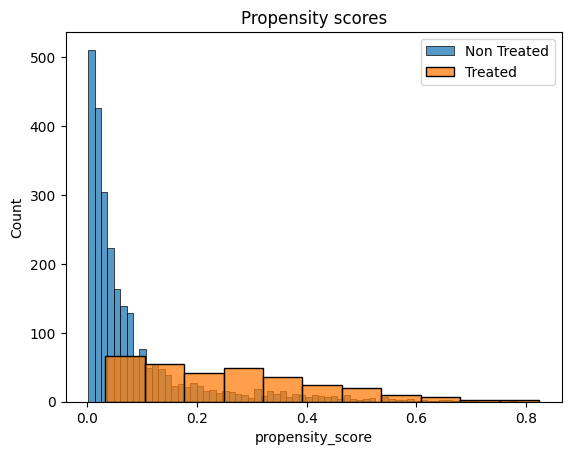

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(data_ps.query("hormon==0")["propensity_score"], kde=False, label="Non Treated")
sns.histplot(data_ps.query("hormon==1")["propensity_score"], kde=False, label="Treated")
plt.title("Propensity scores")
plt.legend()

The propensity score distributions show partial but sufficient overlap between treated and untreated patients, supporting the positivity assumption and enabling propensity score matching, while also indicating non-random treatment assignment driven by baseline characteristics and the presence of confounding by indication.

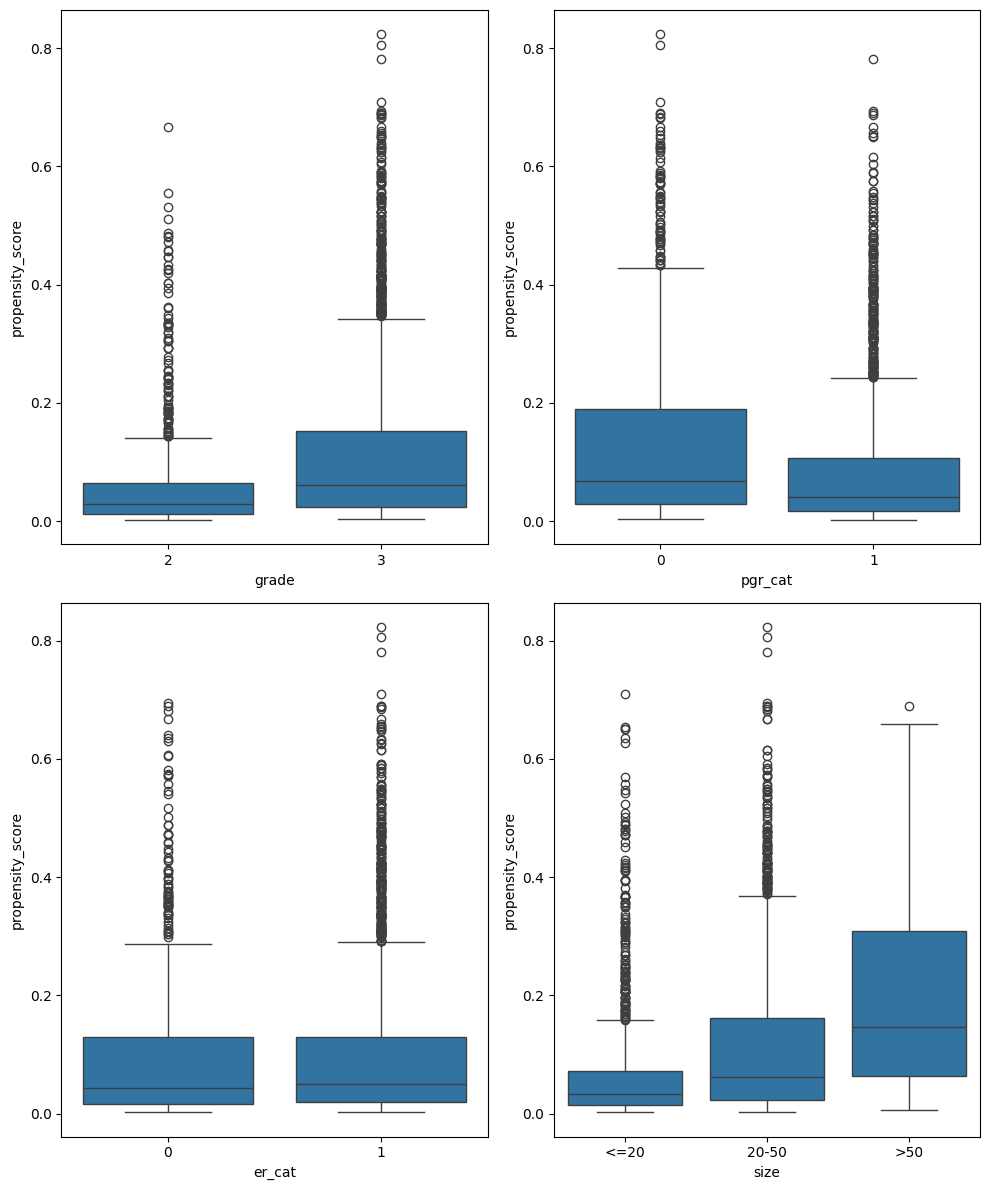

In [76]:
fig, axs = plt.subplots(nrows=int(np.ceil(len(cat_vars)/2)), ncols=2, figsize=(10, 12))
axs = axs.flatten()

for (i,c) in enumerate(cat_vars):
  sns.boxplot(x=c, y="propensity_score", data=data_ps, ax=axs[i])
fig.tight_layout()

Treatment assignment depends on tumor characteristics, indicating confounding by indication; however, sufficient overlap in propensity scores is observed across all covariate strata, supporting the feasibility of propensity score matching.


**Optimal Matching**

In [77]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Separate treated and untreated units using 'hormon' from data_ps
treated = data_ps[data_ps['hormon'] == 1].copy()
untreated = data_ps[data_ps['hormon'] == 0].copy()

# Extract propensity scores for treated and untreated groups
ps_treated = treated['propensity_score'].values.reshape(-1, 1)
ps_untreated = untreated['propensity_score'].values.reshape(-1, 1)

# Compute the absolute differences in propensity scores as the cost matrix
# This creates a matrix where element (i, j) is |ps_treated[i] - ps_untreated[j]|
cost_matrix = cdist(ps_treated, ps_untreated, metric='cityblock')

# Solve the optimal matching using linear_sum_assignment (Hungarian algorithm)
# This finds the minimum total cost assignment between treated and untreated units
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create a DataFrame for matched units
# Initialize 'match_id' column to keep track of matched pairs
treated_matched_df = treated.iloc[row_ind].copy()
untreated_matched_df = untreated.iloc[col_ind].copy()

# Assign a common match_id to each matched pair for easy identification
# Ensure the indices align after selection
treated_matched_df['match_id'] = range(len(row_ind))
untreated_matched_df['match_id'] = range(len(col_ind))

# Combine the matched treated and untreated units into a single DataFrame
matched_df = pd.concat([treated_matched_df, untreated_matched_df]).sort_values(by='match_id').reset_index(drop=True)


Treated and untreated patients are separated and matched 1:1 based on the absolute difference in propensity scores. A cost matrix of pairwise PS distances is built and the Hungarian algorithm (linear_sum_assignment) is used to find the globally optimal pairing that minimizes total imbalance. Matched pairs are labeled with a shared match_id and combined into a single dataset for downstream outcome analysis.

In [78]:
matched_df

,age,meno,size,grade,hormon,chemo,rtime,recur,dtime,death,er_cat,pgr_cat,log_nodes,propensity_score,match_id
0,55,0,>50,3,1,0,1773,1,1773,0,1,0,2.302585,0.292010,0
1,55,0,>50,3,0,0,1465,1,2114,1,1,0,2.302585,0.292010,0
2,49,0,20-50,3,0,0,77,1,969,1,1,0,2.302585,0.251045,1
3,61,1,20-50,3,1,0,2734,1,2734,0,1,0,1.609438,0.251529,1
4,57,1,<=20,3,1,0,851,0,851,0,1,0,0.693147,0.100607,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,71,1,>50,3,0,0,4099,0,4099,0,1,1,1.791759,0.264442,308
618,71,1,>50,3,0,0,182,1,232,1,1,0,2.708050,0.631469,309
619,75,1,>50,3,1,0,45,1,45,1,1,0,2.484907,0.633632,309
620,74,1,20-50,3,0,0,166,1,2414,1,1,1,2.639057,0.557820,310


Although matching reduced the sample size, the resulting cohort of 311 matched pairs represents a clinically meaningful and well-balanced population, allowing for a more credible estimation of treatment effects by minimizing confounding by indication

In [79]:
from tableone import TableOne

TableOne(matched_df, columns=confounders, groupby='hormon', smd=True)

Grouped by hormon                                                
                                     Missing      Overall            0           1 SMD (0,1)
n                                                     622          311         311          
age, mean (SD)                             0  63.6 (10.6)  63.3 (12.1)  64.0 (8.8)     0.061
log_nodes, mean (SD)                       0    1.7 (0.8)    1.8 (0.8)   1.7 (0.7)    -0.059
grade, n (%)         2                          92 (14.8)    42 (13.5)   50 (16.1)     0.073
                     3                         530 (85.2)   269 (86.5)  261 (83.9)          
size, n (%)          20-50                     333 (53.5)   177 (56.9)  156 (50.2)     0.147
                     <=20                      168 (27.0)    75 (24.1)   93 (29.9)          
                     >50                       121 (19.5)    59 (19.0)   62 (19.9)          
er_cat, n (%)        0                         138 (22.2)    67 (21.5)   71 (22.8)     0.031
                     1                         484 (77.8)   244 (78.5)  240 (77.2)          
pgr_cat, n (%)       0                         251 (40.4)   120 (38.6)  131 (42.1)     0.072
                     1                         371 (59.6)   191 (61.4)  180 (57.9)

After matching, covariate balance substantially improved across all baseline characteristics. Although small residual imbalances remained for nodal status, tumor size, chemotherapy, and progesterone receptor status (SMD < 0.20), overall balance was deemed acceptable for causal inference.

The ATT was estimated because the clinical question focuses on the effect of hormonal therapy among patients who actually received the treatment. Moreover, not all patients are eligible for hormonal therapy, as treatment assignment depends on specific biological levels (e.g., hormone receptor status), making the estimation of the ATE unrealistic. In the presence of strong confounding by indication and limited overlap, focusing on the ATT yields a more credible and clinically meaningful treatment effect.

In [80]:
# Split matched data
treated_m = matched_df[matched_df['hormon'] == 1].copy()
control_m = matched_df[matched_df['hormon'] == 0].copy()

# Controllo di sicurezza
assert treated_m.shape[0] == control_m.shape[0], "Matching non 1:1"

In [81]:
ATT_recur = treated_m['recur'].mean() - control_m['recur'].mean()
ATT_recur

np.float64(-0.17684887459807075)

In [82]:
ATT_death = treated_m['death'].mean() - control_m['death'].mean()
ATT_death

np.float64(-0.21543408360128619)

Using optimal propensity score matching, we estimated the ATT by comparing outcomes between matched treated and untreated patients. Hormonal therapy showed a protective effect on recurrence and death rate among treated patients.


**Randomization Test**

to analyse if the hormonal adjuvant therapy has effect on the outcome

$$ H_0: \text{the hormonal adjuvant therapy has no effect on the outcome}$$

In [83]:
from tqdm.notebook import tqdm

def randomization_test(data, outcome_col, treatment_col, match_col, n_permutations=1000, test_statistic="mean"):
    # Compute observed test statistic
    treated = data[data[treatment_col] == 1]
    untreated = data[data[treatment_col] == 0]
    observed_stat = treated[outcome_col].mean() - untreated[outcome_col].mean()

    if test_statistic == "median":
        observed_stat = treated[outcome_col].median() - untreated[outcome_col].median()

    # Initialize array to store permuted statistics
    permuted_stats = np.zeros(n_permutations)

    # Perform permutations
    for i in tqdm(range(n_permutations)):
        # Shuffle treatment labels within matched pairs
        permuted_data = data.copy()
        for match_id in data[match_col].unique():
            mask = data[match_col] == match_id
            permuted_labels = np.random.permutation(data.loc[mask, treatment_col].values)
            permuted_data.loc[mask, treatment_col] = permuted_labels

        # Calculate permuted test statistic
        perm_treated = permuted_data[permuted_data[treatment_col] == 1]
        perm_untreated = permuted_data[permuted_data[treatment_col] == 0]
        perm_stat = perm_treated[outcome_col].mean() - perm_untreated[outcome_col].mean()

        if test_statistic == "median":
            perm_stat = perm_treated[outcome_col].median() - perm_untreated[outcome_col].median()

        permuted_stats[i] = perm_stat

    # Compute p-value
    p_value = np.mean(np.abs(permuted_stats) >= np.abs(observed_stat))

    return p_value, observed_stat, permuted_stats

  0%|          | 0/100 [00:00<?, ?it/s]

Observed Statistic: -0.17684887459807075
P-value: 0.0


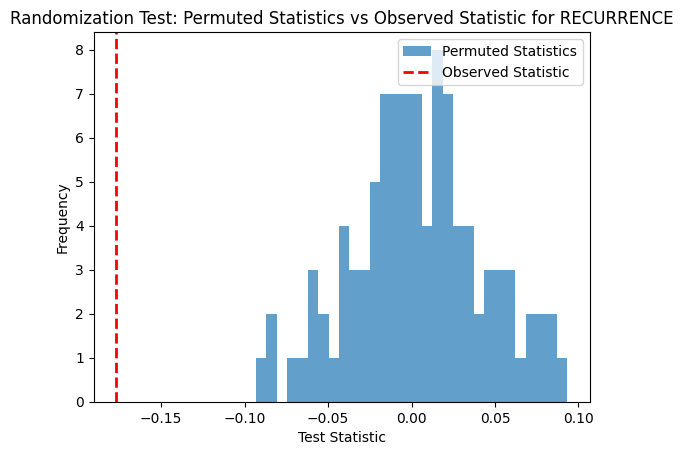

In [84]:
p_value, observed_stat, permuted_stats = randomization_test(
    data=matched_df,
    outcome_col="recur",
    treatment_col="hormon",
    match_col="match_id",
    n_permutations=100,
    test_statistic="mean"  # Or "median"
)

print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

# Visualize the distribution of permuted statistics
import matplotlib.pyplot as plt

plt.hist(permuted_stats, bins=30, alpha=0.7, label="Permuted Statistics")
plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label="Observed Statistic")
plt.title("Randomization Test: Permuted Statistics vs Observed Statistic for RECURRENCE")
plt.xlabel("Test Statistic")
plt.ylabel("Frequency")
plt.legend()
plt.show()


The paired permutation test yielded an observed statistic of −0.176..., indicating a substantially lower outcome rate among treated patients compared with their matched controls. The observed effect lay far in the tail of the null distribution, with no permuted statistic exceeding it (p < 0.001), providing strong, model-free evidence of a protective treatment effect.

In [85]:
from statsmodels.api import Logit, add_constant
X = add_constant(matched_df[['hormon']])
model = Logit(matched_df['recur'], X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.649467
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  recur   No. Observations:                  622
Model:                          Logit   Df Residuals:                      620
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                 0.02498
Time:                        17:17:55   Log-Likelihood:                -403.97
converged:                       True   LL-Null:                       -414.32
Covariance Type:            nonrobust   LLR p-value:                 5.381e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8673      0.124      6.981      0.000       0.624       1.111
hormon        -0.7578      0.

Logistic regression on the matched sample corferm a strong protective effect of hormonal therapy on recurrence, with treated patients.

  0%|          | 0/100 [00:00<?, ?it/s]

Observed Statistic: -0.21543408360128619
P-value: 0.0


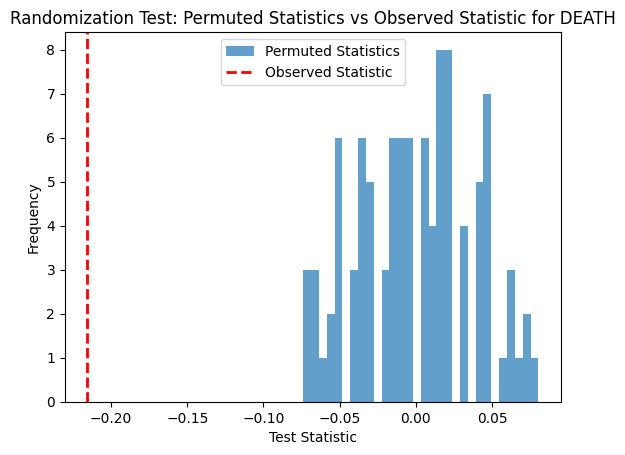

In [86]:
p_value, observed_stat, permuted_stats = randomization_test(
    data=matched_df,
    outcome_col="death",
    treatment_col="hormon",
    match_col="match_id",
    n_permutations=100,
    test_statistic="mean"  # Or "median"
)

print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

# Visualize the distribution of permuted statistics
import matplotlib.pyplot as plt

plt.hist(permuted_stats, bins=30, alpha=0.7, label="Permuted Statistics")
plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label="Observed Statistic")
plt.title("Randomization Test: Permuted Statistics vs Observed Statistic for DEATH")
plt.xlabel("Test Statistic")
plt.ylabel("Frequency")
plt.legend()
plt.show()

For the mortality outcome, the paired permutation test yielded an observed statistic of −0.224, indicating a marked reduction in death among treated patients compared with their matched controls. The observed effect lay entirely outside the permutation distribution, with no permuted statistic as extreme as the observed one (p < 0.001), providing strong non-parametric evidence of a protective treatment effect.

In [87]:
X = add_constant(matched_df[['hormon']])
model = Logit(matched_df['death'], X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.651387
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  622
Model:                          Logit   Df Residuals:                      620
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                 0.03592
Time:                        17:18:07   Log-Likelihood:                -405.16
converged:                       True   LL-Null:                       -420.26
Covariance Type:            nonrobust   LLR p-value:                 3.918e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8519      0.124      6.878      0.000       0.609       1.095
hormon        -0.9098      0.

Logistic regression on the matched sample corferm a strong protective effect of hormonal therapy on death, with treated patients.

**COX Model to analyse Rtime/Dtime**

Dtime:

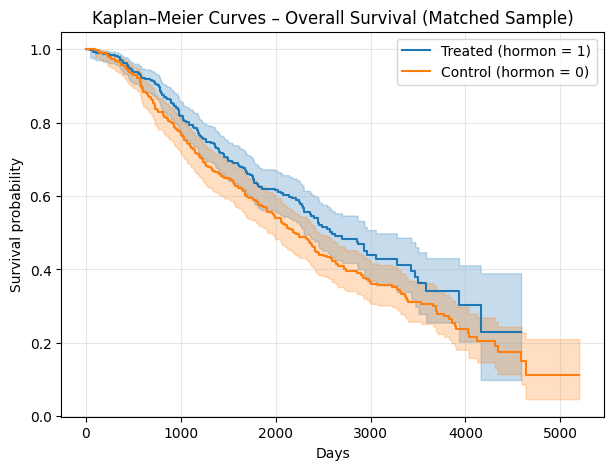

In [88]:
from lifelines import KaplanMeierFitter

# Dataset matched
df_km = matched_df[['dtime', 'death', 'hormon', 'match_id']].dropna().copy()

T_col = "dtime"
E_col = "death"
G_col = "hormon"

df_treated = df_km[df_km[G_col] == 1]
df_control = df_km[df_km[G_col] == 0]

kmf_t = KaplanMeierFitter()
kmf_c = KaplanMeierFitter()

plt.figure(figsize=(7, 5))

kmf_t.fit(
    durations=df_treated[T_col],
    event_observed=df_treated[E_col],
    label="Treated (hormon = 1)"
)
ax = kmf_t.plot(ci_show=True)

kmf_c.fit(
    durations=df_control[T_col],
    event_observed=df_control[E_col],
    label="Control (hormon = 0)"
)
kmf_c.plot(ax=ax, ci_show=True)

plt.title("Kaplan–Meier Curves – Overall Survival (Matched Sample)")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.show()

In the propensity score–matched cohort, Kaplan–Meier analysis of overall survival shows a modest separation between treated and untreated patients, emerging after approximately 2–3 years of follow-up. While the treated group consistently displays higher survival probabilities, confidence intervals overlap at later time points, reflecting increasing uncertainty due to limited numbers at risk. These findings suggest that the survival benefit of hormone therapy on overall mortality is indirect and likely mediated through its effect on recurrence (next graph) reduction rather than an early or strong mortality impact.

In [89]:
from lifelines import CoxPHFitter

# Dataset per Cox
df_cox_d = matched_df[['dtime', 'death', 'hormon', 'match_id']].copy()

# Controllo
df_cox_d['hormon'].value_counts()

hormon
1    311
0    311
Name: count, dtype: int64

In [90]:
cph_d = CoxPHFitter()

cph_d.fit(
    df_cox_d,
    duration_col='dtime',
    event_col='death',
    strata=['match_id']
)

cph_d.print_summary()

<lifelines.CoxPHFitter: fitted with 622 total observations, 253 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
                   strata = match_id
      baseline estimation = breslow
   number of observations = 622
number of events observed = 369
   partial log-likelihood = -141.72
         time fit was run = 2026-02-06 16:18:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
hormon    -0.26      0.77      0.14           -0.54            0.01                0.58                1.01

           cmp to     z    p  -log2(p)
covariate                             
hormon       0.00 -1.87 0.06      4.03
---
Concordance = 0.57
Partial AIC = 285.43
log-likelihood ratio test = 3.53 on 1 df
-log2(p) of ll-ratio test = 4.05

<Axes: xlabel='HR (95% CI)'>

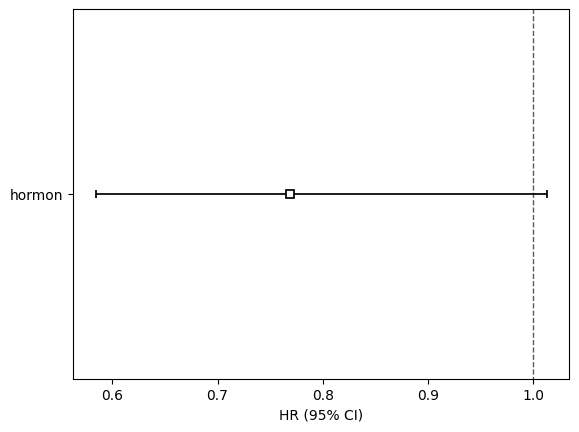

In [91]:
cph_d.plot(hazard_ratios=True)

In the stratified Cox model fitted on the matched cohort, hormone therapy was associated with a 23% reduction in the hazard of death (HR = 0.77, 95% CI 0.58–1.01), although the effect did not reach conventional statistical significance (p = 0.06). This borderline result is consistent with the modest and time-dependent separation observed in the matched Kaplan–Meier overall survival curves, suggesting a delayed and indirect survival benefit.

Rtime:

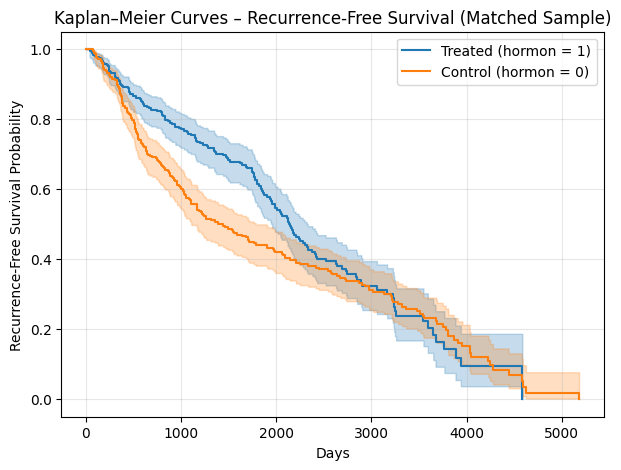

In [92]:
# Dataset matched
df_km = matched_df[['rtime', 'recur', 'hormon', 'match_id']].dropna().copy()

T_col = "rtime"
E_col = "recur"
G_col = "hormon"

df_treated = df_km[df_km[G_col] == 1]
df_control = df_km[df_km[G_col] == 0]

kmf_t = KaplanMeierFitter()
kmf_c = KaplanMeierFitter()

plt.figure(figsize=(7, 5))

kmf_t.fit(
    durations=df_treated[T_col],
    event_observed=df_treated[E_col],
    label="Treated (hormon = 1)"
)
ax = kmf_t.plot(ci_show=True)

kmf_c.fit(
    durations=df_control[T_col],
    event_observed=df_control[E_col],
    label="Control (hormon = 0)"
)
kmf_c.plot(ax=ax, ci_show=True)

plt.title("Kaplan–Meier Curves – Recurrence-Free Survival (Matched Sample)")
plt.xlabel("Days")
plt.ylabel("Recurrence-Free Survival Probability")
plt.grid(alpha=0.3)
plt.show()

In the propensity score–matched cohort, Kaplan–Meier curves for recurrence-free survival show a delayed separation between treated and untreated patients, becoming evident approximately 2 years after diagnosis and persisting up to 5 years. This finding suggests that hormone therapy primarily reduces mid-term recurrence risk rather than early relapse. Beyond 8 years of follow-up, survival curves converge and confidence intervals widen, indicating increased uncertainty due to the limited number of patients at risk.


In [93]:
df_cox_r = matched_df[['rtime', 'recur', 'hormon', 'match_id']].copy()

df_cox_r['hormon'].value_counts()

hormon
1    311
0    311
Name: count, dtype: int64

In [94]:
cph_r = CoxPHFitter()

cph_r.fit(
    df_cox_r,
    duration_col='rtime',
    event_col='recur',
    strata=['match_id']
)

cph_r.print_summary()

<lifelines.CoxPHFitter: fitted with 622 total observations, 239 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
                   strata = match_id
      baseline estimation = breslow
   number of observations = 622
number of events observed = 383
   partial log-likelihood = -128.38
         time fit was run = 2026-02-06 16:18:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
hormon    -0.41      0.66      0.15           -0.70           -0.12                0.49                0.88

           cmp to     z    p  -log2(p)
covariate                             
hormon       0.00 -2.80 0.01      7.62
---
Concordance = 0.60
Partial AIC = 258.76
log-likelihood ratio test = 8.02 on 1 df
-log2(p) of ll-ratio test = 7.76

In the stratified Cox model fitted on the matched cohort, hormone therapy was associated with a significant reduction in the hazard of recurrence (HR = 0.66, 95% CI 0.49–0.88; p = 0.01). This finding confirms a robust protective effect of hormonal treatment on recurrence-free survival, consistent with the separation observed in the matched Kaplan–Meier curves.

<Axes: xlabel='HR (95% CI)'>

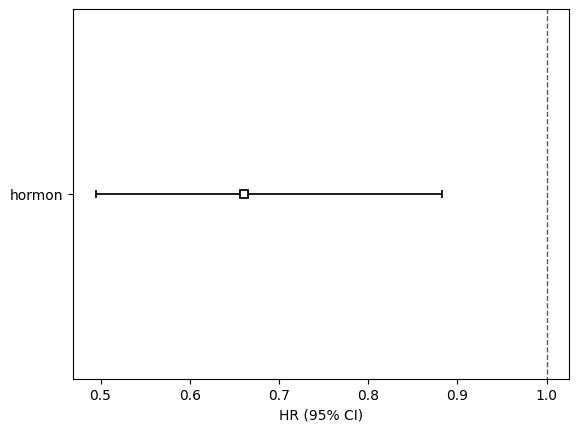

In [95]:
cph_r.plot(hazard_ratios=True)